# Using the picasso trained predictors

This notebook shows how one can use the trained models to make predictions of gas thermodynamics from halo properties.
For a full documentation of the predictor objects and their methods, see {doc}`../api/predictors`.

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM

from picasso import predictors
from picasso.test_data import halos, profs

import seaborn as sns
sns.set_style("darkgrid")
sns.set_theme("notebook")

benchmark = True

We will use the `minimal_576` trained model, which takes as input halo mass and concentration:

In [2]:
predictor = predictors.minimal_576
print(predictor.input_names)

['log M200', 'c200']


## Predicting gas model parameters

First, we want to compute predictions for the model parameter vector, $\vartheta_{\rm gas}$.
To do so, we simply need the vector of scalar halo properties $\vartheta_{\rm halo}$.
We'll use some pre-stored data (containing four halos from the simulations presented in Kéruzoré+24) and write the input vector:

In [3]:
logM200c = halos["log M200"]
c200c = jnp.array(halos["c200"])
theta_halo = jnp.array([logM200c, c200c]).T
print(theta_halo.shape)

(7, 2)


We can then use the `predictor.predict_model_parameters()` function to predict $\vartheta_{\rm gas}$. For a single halo:

In [4]:
theta_gas_0 = predictor.predict_model_parameters(theta_halo[0])
print(theta_gas_0)

[6.8167767e+02 4.2554451e+01 1.1552830e+00 0.0000000e+00 9.0783482e-07
 4.2568062e-02 2.6434088e-01 8.6512649e-01]


The `predictor.predict_model_parameters()` function can also be used for several halos at a time:

In [5]:
theta_gas = predictor.predict_model_parameters(theta_halo)
print(f"{theta_gas=}")
print(f"{theta_gas.shape=}")

theta_gas=Array([[6.81677673e+02, 4.25544624e+01, 1.15528297e+00, 0.00000000e+00,
        9.07834817e-07, 4.25680615e-02, 2.64340878e-01, 8.65126491e-01],
       [1.15930457e+03, 6.67199860e+01, 1.14345777e+00, 0.00000000e+00,
        5.10627331e-07, 3.79818194e-02, 2.71961391e-01, 1.08983898e+00],
       [1.18055396e+03, 6.66861877e+01, 1.13935757e+00, 0.00000000e+00,
        3.46395638e-07, 4.17901538e-02, 3.04681391e-01, 1.08485985e+00],
       [6.25622437e+02, 3.45149117e+01, 1.14486837e+00, 0.00000000e+00,
        2.82427465e-07, 4.93658483e-02, 3.37841868e-01, 8.45696211e-01],
       [8.47131531e+02, 4.71525230e+01, 1.14094687e+00, 0.00000000e+00,
        1.76683585e-07, 4.33129147e-02, 3.45029294e-01, 9.40950334e-01],
       [9.07348572e+02, 5.16159096e+01, 1.14225698e+00, 0.00000000e+00,
        1.27210242e-07, 4.00005803e-02, 3.51588905e-01, 9.78283405e-01],
       [1.83323206e+03, 1.08152756e+02, 1.14192438e+00, 0.00000000e+00,
        7.68364785e-08, 2.49862876e-02, 3.247409

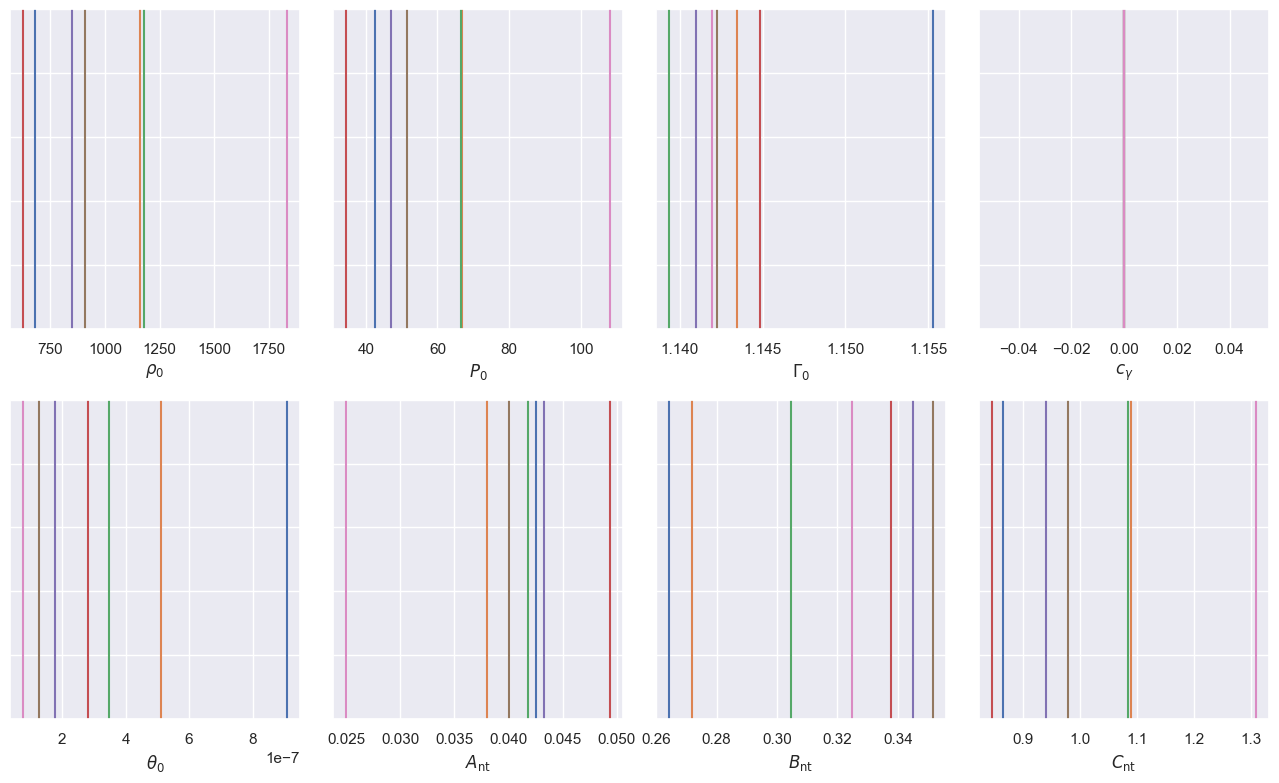

In [6]:
fig, axs = plt.subplots(2, 4, figsize=(13, 8))
axs = axs.flatten()
for ax, q in zip(axs, theta_gas.T):
    for i in range(len(logM200c)):
        ax.plot([q[i], q[i]], [0, 1])
    ax.set_yticklabels([])
    ax.set_ylim(0, 1)
    
axs[0].set_xlabel("$\\rho_0$")
axs[1].set_xlabel("$P_0$")
axs[2].set_xlabel("$\\Gamma_0$")
axs[3].set_xlabel("$c_\\gamma$")
axs[4].set_xlabel("$\\theta_0$")
axs[5].set_xlabel("$A_{\\rm nt}$")
axs[6].set_xlabel("$B_{\\rm nt}$")
axs[7].set_xlabel("$C_{\\rm nt}$")
fig.tight_layout()


It can also be just-in-time compiled:

In [7]:
if benchmark:
    predict_jit = jax.jit(predictor.predict_model_parameters)
    print("Not jitted:", end=" ")
    %timeit _ = predictor.predict_model_parameters(theta_halo)
    print("jitted:", end=" ")
    _ = predict_jit(theta_halo)
    %timeit _ = predict_jit(theta_halo)

Not jitted: 8.8 ms ± 180 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
jitted: 10.6 µs ± 101 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


## Predicting gas thermodynamics

With a prediction for $\vartheta_{\rm gas}$, we can use `picasso.polytrop` and `picasso.nonthermal` to predict gas thermodynamics (see {myst_nb:doc}`demo_model`).
`PicassoPredictor` objects also offers a wrapper function that predicts all thermodynamic properties directly from an input vector $\vartheta_{\rm halo}$ and a potential distribution.
Assuming the halos above are NFW, we can predict their potential profiles:

In [8]:
r_R500c, phi = profs["r_R500"], profs["phi"]

Then, we can make predictions of gas thermodynamics for one halo:

In [9]:
rho_g, P_tot, P_th, f_nt = predictor.predict_gas_model(theta_halo[0], phi[0], r_R500c[0], r_R500c[0] / 2)

Or for all halos at the same time (this function uses `jax.vmap` to vectorize the predictions):

In [10]:
rho_g, P_tot, P_th, f_nt = predictor.predict_gas_model(theta_halo, phi, r_R500c, r_R500c / 2)

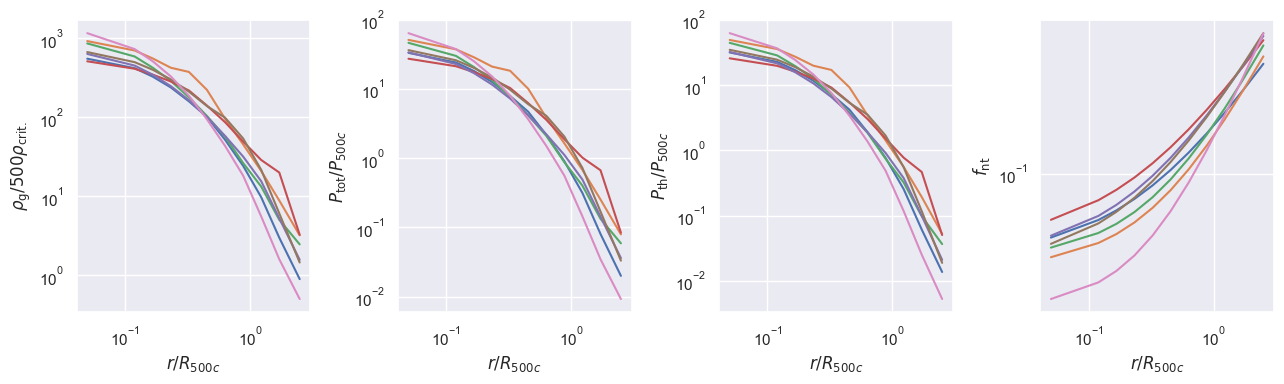

In [11]:
fig, axs = plt.subplots(1, 4, figsize=(13, 4))
for ax, q in zip(axs, [rho_g, P_tot, P_th, f_nt]):
    ax.loglog(r_R500c.T, q.T)
    ax.set_xlabel("$r / R_{500c}$")

axs[0].set_ylabel("$\\rho_{\\rm g} / 500 \\rho_{\\rm crit.}$")
axs[1].set_ylabel("$P_{\\rm tot} / P_{500c}$")
axs[2].set_ylabel("$P_{\\rm th} / P_{500c}$")
axs[3].set_ylabel("$f_{\\rm nt}$")
fig.tight_layout()

Again, these functions can be just-in-time compiled:

In [12]:
if benchmark:
    predict_jit = jax.jit(predictor.predict_gas_model)

    print("1 halo, not jitted:", end=" ")
    %timeit _ = predictor.predict_gas_model(theta_halo[0], phi[0], r_R500c[0], r_R500c[0] / 2)
    print("1 halo, jitted:", end=" ")
    _ = predict_jit(theta_halo[0], phi[0], r_R500c[0], r_R500c[0] / 2)
    %timeit _ = predict_jit(theta_halo[0], phi[0], r_R500c[0], r_R500c[0] / 2)

    print("4 halo, not jitted:", end=" ")
    %timeit _ = predictor.predict_gas_model(theta_halo, phi, r_R500c, r_R500c / 2)
    print("4 halo, jitted:", end=" ")
    _ = predict_jit(theta_halo, phi, r_R500c, r_R500c / 2)
    %timeit _ = predict_jit(theta_halo, phi, r_R500c, r_R500c / 2)

1 halo, not jitted: 9.61 ms ± 460 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1 halo, jitted: 160 µs ± 3.51 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
4 halo, not jitted: 15 ms ± 127 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4 halo, jitted: 27.2 µs ± 226 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Differentiating predictions

Since the model prediction functions described above are entirely implemented in JAX, they are fully differentiable.
Let's start by defining an untrained predictor, such that the prediction functions take as input a dict of neural network parameters $\vartheta_{\rm net}$.

In [13]:
model = predictors.PicassoPredictor(
    predictors.FlaxRegMLP(2, 8, [8,], ["selu", "selu", "sigmoid"]),
    predictor._transform_x,
    predictor._transform_y,
    input_names=predictor.input_names
)

For demonstration purposes, we use an MLP with 2 input features, one hidden layer with 8 features, and 8 output features.
`flax` allows us to initialize $\vartheta_{\rm net}$ easily:

In [14]:
theta_nn = model.mlp.init(jax.random.PRNGKey(44), jnp.ones(model.mlp.X_DIM))
print(f"{theta_nn=}")

theta_nn={'params': {'input': {'kernel': Array([[ 0.03842447, -0.06375846],
       [ 1.4234861 , -0.33939242]], dtype=float32), 'bias': Array([0., 0.], dtype=float32)}, 'dense1': {'kernel': Array([[-0.042185  , -0.7779425 ,  1.1562326 , -0.2546578 , -0.5690918 ,
         0.56547344,  0.03781918, -0.47313142],
       [ 1.0343004 ,  0.09225573,  0.04856016, -0.36422998, -0.2005813 ,
        -1.1775992 ,  0.5434312 ,  1.2453555 ]], dtype=float32), 'bias': Array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}, 'output': {'kernel': Array([[ 7.8989536e-02,  7.0438385e-01,  1.0798373e-01, -3.7004817e-01,
        -7.8189468e-01,  3.6114028e-01,  7.4631339e-01,  8.4025212e-02],
       [-2.6573351e-04,  3.7197936e-01, -6.9597310e-01, -1.7070572e-01,
        -6.5567094e-01,  1.4083256e-01, -6.4938289e-01, -5.2993375e-01],
       [-6.3911790e-01,  8.5570492e-02, -2.9292062e-01, -7.5498748e-01,
         8.8445395e-02,  8.0396719e-02,  1.2768888e-01,  2.5018033e-01],
       [-1.9778068e-01,  5.100

Now, we can write a loss function.
For example, let's write a mean square error function that compares the predictions of model parameters, $\vartheta_{\rm gas}$, with the ones obtained above from the trained network:

In [15]:
def loss_fn_predict_parameters(theta_nn):
    # ... insert your code here
    diff = model.predict_model_parameters(theta_halo, theta_nn) - theta_gas
    return jnp.mean(diff ** 2)

We can use `jax.value_and_grad` to compute, for an input $\vartheta_{\rm net}$, the value of the loss function and its gradients with respect to the components of $\vartheta_{\rm net}$:

In [16]:
loss_fn_and_grads = jax.jit(jax.value_and_grad(loss_fn_predict_parameters))
loss, grads = loss_fn_and_grads(theta_nn)
print(f"{loss=}")
print(f"{grads=}")

loss=Array(128455., dtype=float32)
grads={'params': {'dense1': {'bias': Array([ 147310.92 ,   19603.268, -597746.06 , -267960.62 , -198538.36 ,
        398719.47 ,  795577.7  , -433891.38 ], dtype=float32), 'kernel': Array([[  47773.746 ,    7353.176 , -182610.25  ,  -78405.016 ,
         -58240.777 ,  124436.46  ,  241393.5   , -130174.19  ],
       [ -23227.129 ,   -3562.3755,   89067.945 ,   38487.43  ,
          28715.145 ,  -60609.43  , -117769.96  ,   64012.723 ]],      dtype=float32)}, 'input': {'bias': Array([ -74108.24, -506463.34], dtype=float32), 'kernel': Array([[ -25764.783, -188868.97 ],
       [ -16642.59 ,  -97089.78 ]], dtype=float32)}, 'output': {'bias': Array([ 8.9572638e+05,  4.1748895e+04,  9.4424991e-04, -2.0107020e-02,
        1.0677524e-13, -1.9322436e-04, -2.5177558e-03,  3.4172133e-01],      dtype=float32), 'kernel': Array([[-2.41113109e+05, -1.38211543e+04, -2.81920540e-04,
         6.79508969e-03, -3.38970490e-14,  5.53081591e-05,
         6.38443918e-04, -1

This loss function can then be optimized using, *e.g.*, `optax` (See the `optax` docs [here](https://optax.readthedocs.io/en/latest/index.html), in particular the tutorial to optimize the parameters of a `flax` model [here](https://optax.readthedocs.io/en/latest/_collections/examples/flax_example.html)).